# <left>Name : Xin Tong Wang </left>
# <right>Student ID: 260640319</right>

# <center> Summary of Thompson Sampling </center>
### What?
Thompson sampling is a sampling algorithm introduced in 1933. It is similar to the Greedy Algorithm in that it generates a success probability estimate for each arm. However, instead of taking the Expected value of the distribution, the Thompson sampling agent samples this success probability from a posterior distribution. The action with the highest success probability is chosen, and its reward is used to update the posterior distribution.

### Why?
A Greedy Agent may get "stuck" exploring an action which is not optimal. It will repeatedly choose the arm which it considers best, but may not be optimal due to the stochastic property of the bandit. Thus, even over large time steps, the probabilities of pulling each arm may not change.
Thompson sampling tries all actions which could potentially be optimal, and discards those that do not perform on par with others, thus preventing the agent from being "stuck".

Moreover, Thompson Sampling converges towards the optimal action faster than the Greedy and $\epsilon$-Greedy agents.
This is because Thompson Sampling performs exploration in an informative way, as opposed to a random way for the $\epsilon$-Greedy algorithm.
Finally, Thompson Sampling, along with UCB bandits display logarithmic regret whereas greedy bandits display linear regret. This can be seen in the experimentations below.

### However...
1. Using Thompson sampling incurs a cost of exploration, whereas this cost is minimal in the Greedy Agent's case. This means that Thompson sampling is weak at performing low-exploration tasks, such as sequential learning.
2. Thompson Sampling often requires much more time exploring than the Greedy Agent. This means that if the problem is time-sensitive (ie. limit of time steps), it may be better to repeated exploit a close-to-optimal arm, instead of spending valuable time exploring.
3. Non-stationary problems are constantly changing, which leads to information obtained to become deprecated. Thompson Sampling needs too much time to find an optimal action, and thus, the problem may change before the optimal action can be exploited.
4. When an arm provides information non-proportional to reward, Thompson Sampling fails to capitalize on the information. For example, if one arm dictates the reward for other arms, but offers a low reward, Thompson Sampling will gradually ignore the arm.

# <center> Experimentation </center>
## In the experiments below, we compare the empirical regret for:


####  - Greedy Agent 
####  - $\epsilon$-Greedy Agent 
####  - Upper Confidence Bound Agent 
####  - Thompson Sampling Agent 

## Different contexts will be explored to observe the behaviour of the various bandits.

####  - Bernoulli Arms
####  - Beta Arms
####  - Uniform arms
####  - Dynamic arms

In [1]:
from random import Random
import numpy as np
from matplotlib import pyplot as plt
import math

### We define types of arms, each with a different family of reward distributions

In [2]:
class GaussianArm():
    def __init__(self, mu, sigma, seed):
        self.mu = mu
        self.sigma = sigma
        
        #Seed a random generator for this arm for reproducibility purposes
        self.randomGenerator = np.random.RandomState(seed)
        
    def pull(self):
        return self.randomGenerator.normal(self.mu, self.sigma)
    
    def __str__(self):
        return "GaussianArm (mu = {}, sigma = {})".format(self.mu, self.sigma)

class UniformArm():
    def __init__(self, low, high, seed):
        self.low = low
        self.high = high
        
        #Seed a random generator for this arm for reproducibility purposes
        self.randomGenerator = np.random.RandomState(seed)
        self.exp = (low + high) /2
        
    def pull(self):
        return self.randomGenerator.uniform(self.low, self.high)
    
    def __str__(self):
        return "UniformArm (low = {}, high = {})".format(self.low, self.high)

class BetaArm():
    def __init__(self, alpha, beta, seed):
        self.alpha = alpha
        self.beta = beta
        
        #Seed a random generator for this arm for reproducibility purposes
        self.randomGenerator = np.random.RandomState(seed)
        
        #expected mean
        self.exp = alpha / (alpha + beta)
        
    def pull(self):
        return self.randomGenerator.beta(self.alpha, self.beta)
    
    def __str__(self):
        return "BetaArm (alpha = {}, beta = {})".format(self.alpha, self.beta)
    
class BernoulliArm():
    def __init__(self, theta, seed):
        self.theta = theta
        self.randomGenerator = np.random.RandomState(seed)
        
        #expected mean
        self.exp = theta
        
    def pull(self):
        return self.randomGenerator.binomial(n = 1, p = self.theta)
    
    def __str__(self):
        return "BernoulliArm (theta = {})".format(self.theta)

### Define an n-arm Bandit which contains strategies

In [3]:
class nArmBandit():
    def __init__(self, nArms, typeArms, seed):
        
        self.seed = seed
        self.nArms = nArms
        
        #Random Generator for the bandit
        np.random.seed(self.seed)
        
        self.arms = []
        #insert the necessary number of arms
        for i in range(nArms):
            if typeArms == "Gaussian":
                self.arms.append(GaussianArm(mu =np.random.rand(), sigma =np.random.rand(), seed =np.random.randint(0,1000)))
            if typeArms == "Uniform":
                low = np.random.uniform(0,1)
                high = np.random.uniform(low, 1)
                self.arms.append(UniformArm(low =low, high =high, seed =np.random.randint(0,1000)))
            if typeArms == "Beta":
                self.arms.append(BetaArm(alpha =np.random.rand(), beta =np.random.rand(), seed =np.random.randint(0,1000)))
            if typeArms == "Bernoulli":
                self.arms.append(BernoulliArm(theta =np.random.rand(), seed =np.random.randint(0,1000)))
        
    def stats(self):
        for i in range(len(self.arms)):
            print("[{}] : {}".format(i, str(self.arms[i])))
            
    #Thompson Sampling Strategy
    def ThompsonSamplingAgent(self, num_steps, plot = True):
         
        #Storing Values
        pulledArms = []
        rewards = []
        regrets = []
        
        #Get the optimal reward for regret calculation later
        r_opt = max([x.exp for x in self.arms])
        #print(r_opt)
        
        
        #Random Generator
        myGenerator = np.random.RandomState(self.seed)
        
        #For each arm i, initialize S_i = 0, F_i = 0
        Successes = [0]*self.nArms
        Failures = [0]*self.nArms
        
        #Loop through t = 1, 2, ..., num_steps
        for t in range(1,num_steps):
            #print(pulledArms)
            #Loop through arms
            
            theta_list = []
            for i in range(self.nArms):
                #Sample Theta from Beta(S_i + 1, F_i + 1)
                theta = myGenerator.beta(Successes[i]+1, Failures[i]+1)
                theta_list.append(theta)
            
            #Find arm which has the highiest theta value
            BestArmIndex = theta_list.index(max(theta_list))
            
            #Play best arm, obtain r_tilde
            r_t_tilde = self.arms[BestArmIndex].pull()
            
            #update regret
            u_i = self.arms[BestArmIndex].exp
            #rewards.append(u_i)
            
            if t == 1:
                regrets.append(r_opt - u_i)
                rewards.append(r_t_tilde)
            else:
                regrets.append(regrets[-1] + r_opt - u_i)
                rewards.append(rewards[-1] + (r_t_tilde - rewards[-1]) / float(t))
            
            #Perform Bernoulli trial with success probability r_tilde
            #Note that binomial with n=1 is bernoulli
            r_t = np.random.binomial(size=1, n=1, p= r_t_tilde)
            
            #Update the distribution
            if r_t == 1:
                Successes[BestArmIndex] += 1
            else:
                Failures[BestArmIndex] += 1
            
            #store the best arm pulled in our list
            pulledArms.append(BestArmIndex)
            
        return regrets,rewards
    
    
    def EpsilonGreedyAgent(self, num_steps, epsilon):
        
        #storing values
        armAverages = [0.0] * self.nArms
        regrets = []
        rewards = []
        
        r_opt = max([x.exp for x in self.arms])
        #print(r_opt)
        
        for t in range(1, num_steps):
            #print("Avg at t={}: {}".format(t,armAverages))
   
            #for probability 1-epsilon, we play the best arm, and the rest of the time, we play a random arm
            if (np.random.binomial(size=1, n=1, p= 1-epsilon) == 1):

                maxAvg = max(armAverages)
                
                #tiebreaking if many have the same max average
                if armAverages.count(maxAvg) > 1 :
                    temp = []
                    for i in range(len(armAverages)):
                        if armAverages[i] == maxAvg:
                            temp.append(i)
                    choice = np.random.choice(temp)
                    #print("TEMP : {} , choice: {}".format(temp,choice))
                    
                    BestArmIndex = choice
                else:
                    BestArmIndex = armAverages.index(maxAvg)
                #print("Best Arm Chosen: {}".format(BestArmIndex))  
            else:
                BestArmIndex = np.random.randint(low = 0, high = self.nArms)
                #print("Arm Chosen: {}".format(BestArmIndex))   
                
            result = self.arms[BestArmIndex].pull()
            #update the chosen arm's average (incremental averaging)
            armAverages[BestArmIndex] = armAverages[BestArmIndex] + (result - armAverages[BestArmIndex]) / float(t)
            
            u_i = self.arms[BestArmIndex].exp
            
            if t == 1:
                regrets.append(r_opt - u_i)
                rewards.append(result)
            else:
                regrets.append(regrets[-1] + r_opt - u_i)
                rewards.append(rewards[-1] + (result - rewards[-1])/float(t))    
        return regrets,rewards

    def ucbAgent(self, num_steps, c):
        #storing values
        armAverages = [0.0] * self.nArms
        armCounts = [0] * self.nArms

        r_opt = max([x.exp for x in self.arms])
        
        regrets = []
        rewards = []
        
        for t in range(1,num_steps):
            
            #for the first K rounds, we choose the arms once each
            if (t <= self.nArms):
                maxIndex = t-1
            else:
                #compute each arm's "value" at time t
                maxIndex = -1
                maxVal = -1

                for i in range(self.nArms):
                    #upper bound calculation
                    v_i = armAverages[i] + c * math.sqrt( math.log(t , 2) / armCounts[i])
                    if (v_i > maxVal):
                        maxIndex = i
                        maxVal = v_i
            
            #Pull the arm corresponding to highiest value
            r_i = self.arms[maxIndex].pull()
            
            #update the average and count of the arm pulled
            armCounts[maxIndex] += 1
            armAverages[maxIndex] = armAverages[maxIndex] + (r_i - armAverages[maxIndex]) / armCounts[maxIndex]

            u_i = self.arms[maxIndex].exp
            
            #store results
            if t == 1:
                regrets.append(r_opt - u_i)
                rewards.append(r_i)
            else:
                regrets.append(regrets[-1] + r_opt - u_i)
                rewards.append(rewards[-1] + (r_i - rewards[-1])/float(t))

        return regrets,rewards
    
    def plot_results(self):

        #Greedy Bandit
        Greedy_Regret, Greedy_Reward            = self.EpsilonGreedyAgent(num_timesteps, 0.0)

        #Epsilon-Greedy Bandit with Epsilon = 0.01 and 0.1
        E_Greedy_Regret1, E_Greedy_Reward1      = self.EpsilonGreedyAgent(num_timesteps, 0.01)
        E_Greedy_Regret2, E_Greedy_Reward2      = self.EpsilonGreedyAgent(num_timesteps, 0.1)

        #UCB Bandit with c = 1 and 2
        UCB_Regret1, UCB_Reward1                = self.ucbAgent(num_timesteps, 1)
        UCB_Regret2, UCB_Reward2                = self.ucbAgent(num_timesteps, 2)

        #Thompson Sampling Bandit
        Thompson_Regret, Thompson_Reward        = self.ThompsonSamplingAgent(num_timesteps)
        
        #Plotting
        graph_fig = plt.figure(figsize=(12,9))
        ax = graph_fig.add_subplot(1,1,1)

        ax.plot(Greedy_Regret)
        ax.plot(E_Greedy_Regret1)
        ax.plot(E_Greedy_Regret2)
        ax.plot(UCB_Regret1)
        ax.plot(UCB_Regret2)
        ax.plot(Thompson_Regret)

        ax.set_xlabel('Time Step')
        ax.set_ylabel('Cumulative Regret')

        ax.legend(['Greedy',
                   '$\epsilon$-greedy ($\epsilon$=0.01)',
                   '$\epsilon$-greedy ($\epsilon$=0.10)',
                   'Upper Confidence Bound (c=1)',
                   'Upper Confidence Bound (c=2)',
                   'Thompson Sampling'
                  ])

        return graph_fig      
            

### Set the number of TimeSteps that the bandits will run for

In [4]:
num_timesteps = 50000

# <center> Bernoulli Bandit </center>

## 10-arm Bernoulli Bandit

In [5]:
BernoulliBandit = nArmBandit(10,"Bernoulli", 30)
BernoulliBandit.stats()

[0] : BernoulliArm (theta = 0.644143536068)
[1] : BernoulliArm (theta = 0.218256903164)
[2] : BernoulliArm (theta = 0.163650726103)
[3] : BernoulliArm (theta = 0.706414396663)
[4] : BernoulliArm (theta = 0.991750992294)
[5] : BernoulliArm (theta = 0.696650949014)
[6] : BernoulliArm (theta = 0.406690101625)
[7] : BernoulliArm (theta = 0.17701685834)
[8] : BernoulliArm (theta = 0.974305002144)
[9] : BernoulliArm (theta = 0.933850143319)


### 10-arm Bernoulli Bandit Regret for Greedy, Epsilon-Greedy, Upper Confidence Bound and Thompson Sampling

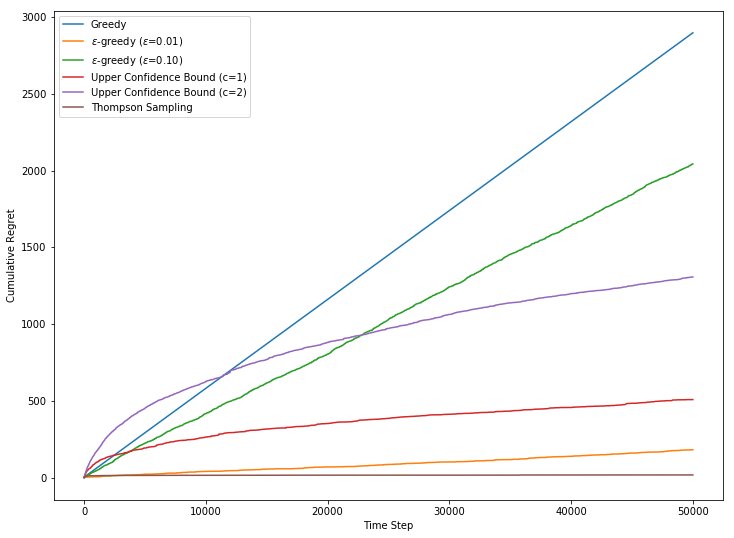

In [6]:
BernoulliBandit.plot_results()

## 100-arm Bernoulli Bandit

In [7]:
BernoulliBandit_100 = nArmBandit(100,"Bernoulli", 140)
#BernoulliBandit_100.stats()

### 100-arm Bernoulli Bandit Regret for Greedy, Epsilon-Greedy, Upper Confidence Bound and Thompson Sampling

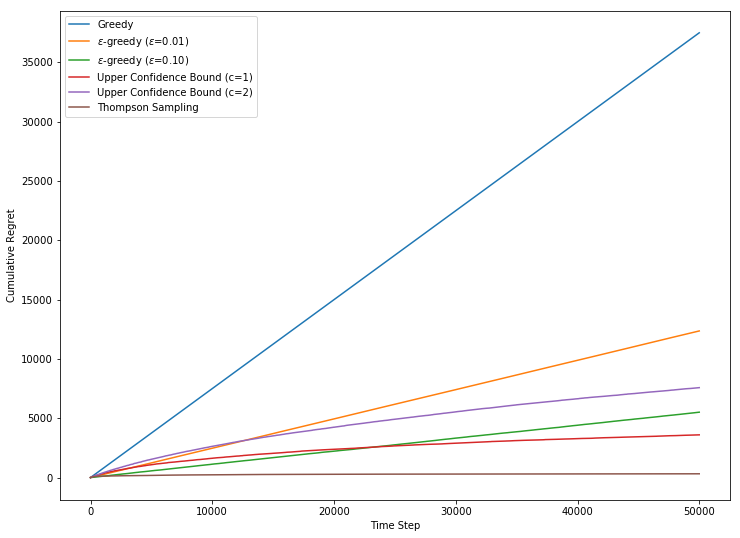

In [8]:
BernoulliBandit_100.plot_results()

It is interesting to note that as the number of arms increases, UCB does not provide as large of advantage over Greedy algorithms

# <center> Beta Bandit </center>
## 10-arm Beta Bandit 

In [9]:
BetaBandit = nArmBandit(10,"Beta", 350)
BetaBandit.stats()

[0] : BetaArm (alpha = 0.432131199353, beta = 0.716248622616)
[1] : BetaArm (alpha = 0.604123862708, beta = 0.196227227315)
[2] : BetaArm (alpha = 0.0325679804342, beta = 0.468734074025)
[3] : BetaArm (alpha = 0.805524218521, beta = 0.56047098212)
[4] : BetaArm (alpha = 0.126210054364, beta = 0.352913411845)
[5] : BetaArm (alpha = 0.703612972191, beta = 0.599287435197)
[6] : BetaArm (alpha = 0.684915924476, beta = 0.856966800679)
[7] : BetaArm (alpha = 0.742914297793, beta = 0.265295123099)
[8] : BetaArm (alpha = 0.873745331591, beta = 0.587348423842)
[9] : BetaArm (alpha = 0.827857900386, beta = 0.34808842279)


### 10-arm Beta Bandit Regret for Greedy, Epsilon-Greedy, Upper Confidence Bound and Thompson Sampling

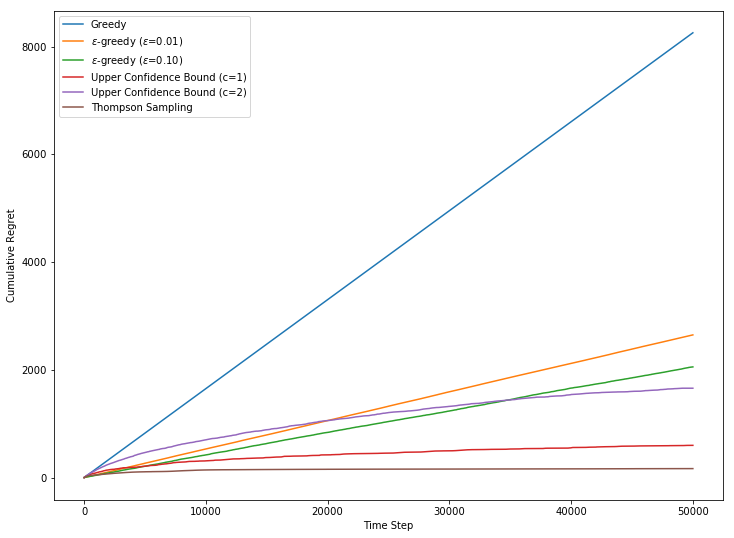

In [10]:
BetaBandit.plot_results()

## 100-arm Beta Bandit 

In [11]:
BetaBandit_100 = nArmBandit(100,"Beta", 351)

### 100-arm Beta Bandit Regret for Greedy, Epsilon-Greedy, Upper Confidence Bound and Thompson Sampling


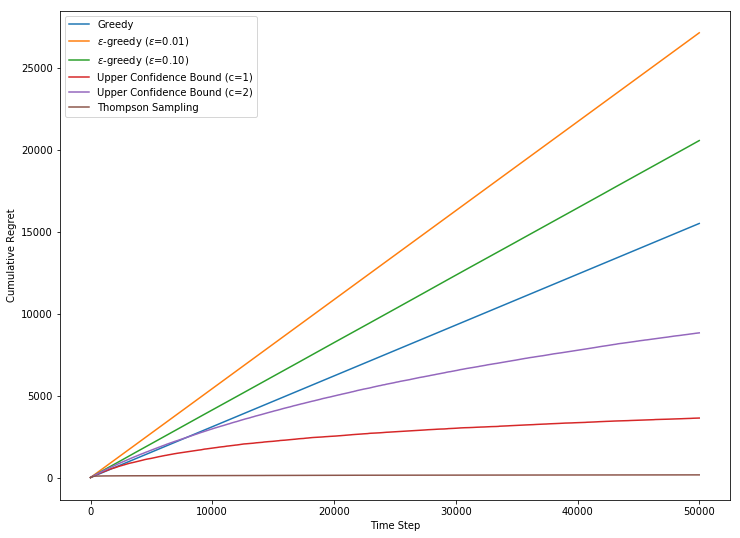

In [12]:
BetaBandit_100.plot_results()

# <center> Uniform Bandit </center>
## 10-arm Uniform Bandit

In [13]:
UniformBandit = nArmBandit(10,"Uniform", 40)
UniformBandit.stats()

[0] : UniformArm (low = 0.40768702808, high = 0.440481051842)
[1] : UniformArm (low = 0.287305184789, high = 0.608267713148)
[2] : UniformArm (low = 0.134079817879, high = 0.282536343806)
[3] : UniformArm (low = 0.776775457725, high = 0.929961434902)
[4] : UniformArm (low = 0.523970049626, high = 0.925291075932)
[5] : UniformArm (low = 0.708645152163, high = 0.716667514759)
[6] : UniformArm (low = 0.401724975183, high = 0.9709478227)
[7] : UniformArm (low = 0.835300175947, high = 0.868610423231)
[8] : UniformArm (low = 0.65381633825, high = 0.852411479889)
[9] : UniformArm (low = 0.957399109086, high = 0.992899847995)


### 10-arm Uniform Bandit Regret for Greedy, Epsilon-Greedy, Upper Confidence Bound and Thompson Sampling

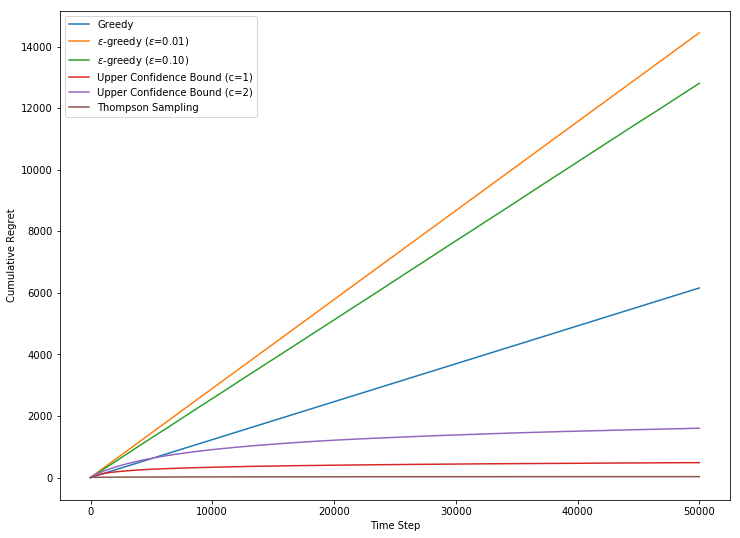

In [14]:
UniformBandit.plot_results()

# 100-arm Uniform Bandit

In [15]:
UniformBandit_100 = nArmBandit(100,"Uniform", 41)
#UniformBandit_100.stats()

### 100-arm Uniform Bandit Regret for Greedy, Epsilon-Greedy, Upper Confidence Bound and Thompson Sampling

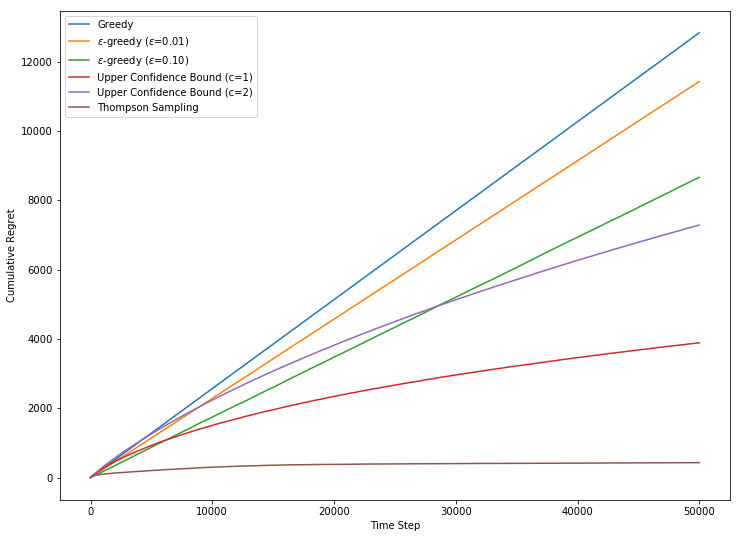

In [16]:
UniformBandit_100.plot_results()

### Analysis for Bernoulli, Beta and Uniform Bandits
From our experiments, we see that Both UCB and Thompson Sampling do indeed provide Logarithmic empirical cumulative regret.

Greedy algorithms result in linear cumulative regret.

# <center> Dynamic Bandit </center>
#### This bandit is an n-armed bernoulli bandit which will change its arms' distributions over time. This will simulate a changing environment.
- Initially, n arms are set
- After a number of time steps, all arms are changed to new arms

In [17]:
import time

#every changeTime steps, the arms will change
changeTime = 5

class nArmedDynamicBandit():
    def __init__(self, nArms, seed):
        
        self.seed = seed
        self.nArms = nArms
        
        #Random Generator for the bandit
        np.random.seed(self.seed)
        
        self.arms = []
        #insert the necessary number of arms
        for i in range(nArms):
            self.arms.append(BernoulliArm(theta =np.random.rand(), seed =np.random.randint(0,342)))
        
    def stats(self):
        for i in range(len(self.arms)):
            print("[{}] : {}".format(i, str(self.arms[i])))
            
    def changeArms(self):
        #Randomly change all arms, using current time as seed
        for i in range(self.nArms):
            self.arms[i] = (BernoulliArm(theta =np.random.rand(), seed =np.random.randint(0,int(time.time()))))
            
    def ThompsonSamplingAgent(self, num_steps):
         
        #Storing Values
        pulledArms = []
        rewards = []
        regrets = []
        
        #Get the optimal reward for regret calculation later
        r_opt = max([x.exp for x in self.arms])
        
        
        #Random Generator
        myGenerator = np.random.RandomState(self.seed)
        
        #For each arm i, initialize S_i = 0, F_i = 0
        Successes = [0]*self.nArms
        Failures = [0]*self.nArms
        
        #Loop through t = 1, 2, ..., num_steps
        for t in range(1,num_steps):
            
            #every changeTime steps, we'll change all arms
            if t % changeTime == 0:
                self.changeArms()
                r_opt = max([x.exp for x in self.arms])
                
            #Loop through arms
            
            theta_list = []
            for i in range(self.nArms):
                #Sample Theta from Beta(S_i + 1, F_i + 1)
                theta = myGenerator.beta(Successes[i]+1, Failures[i]+1)
                theta_list.append(theta)
            
            #Find arm which has the highiest theta value
            BestArmIndex = theta_list.index(max(theta_list))
            
            #Play best arm, obtain r_tilde
            r_t_tilde = self.arms[BestArmIndex].pull()
            
            #update regret
            u_i = self.arms[BestArmIndex].exp
            #rewards.append(u_i)
            
            if t == 1:
                regrets.append(r_opt - u_i)
                rewards.append(r_t_tilde)
            else:
                regrets.append(regrets[-1] + r_opt - u_i)
                rewards.append(rewards[-1] + (r_t_tilde - rewards[-1]) / float(t))
            
            #Perform Bernoulli trial with success probability r_tilde
            #Note that binomial with n=1 is bernoulli
            r_t = np.random.binomial(size=1, n=1, p= r_t_tilde)
            
            #Update the distribution
            if r_t == 1:
                Successes[BestArmIndex] += 1
            else:
                Failures[BestArmIndex] += 1
            
            #store the best arm pulled in our list
            pulledArms.append(BestArmIndex)
            
        
        #Plot if needed
        return regrets,rewards
    
    
    def EpsilonGreedyAgent(self, num_steps, epsilon):
        
        #storing values
        armAverages = [0.0] * self.nArms
        regrets = []
        rewards = []
        
        r_opt = max([x.exp for x in self.arms])
        #print(r_opt)
        
        for t in range(1, num_steps):
            #every changeTime steps, we'll change all arms
            if t % changeTime == 0:
                self.changeArms()
                r_opt = max([x.exp for x in self.arms])
            
            #print("Avg at t={}: {}".format(t,armAverages))
   
            #for probability 1-epsilon, we play the best arm, and the rest of the time, we play a random arm
            if (np.random.binomial(size=1, n=1, p= 1-epsilon) == 1):

                maxAvg = max(armAverages)
                
                #tiebreaking if many have the same max average
                if armAverages.count(maxAvg) > 1 :
                    temp = []
                    for i in range(len(armAverages)):
                        if armAverages[i] == maxAvg:
                            temp.append(i)
                    choice = np.random.choice(temp)
                    #print("TEMP : {} , choice: {}".format(temp,choice))
                    
                    BestArmIndex = choice
                else:
                    BestArmIndex = armAverages.index(maxAvg)
                #print("Best Arm Chosen: {}".format(BestArmIndex))  
            else:
                BestArmIndex = np.random.randint(low = 0, high = self.nArms)
                #print("Arm Chosen: {}".format(BestArmIndex))   
                
            result = self.arms[BestArmIndex].pull()
            #update the chosen arm's average (incremental averaging)
            armAverages[BestArmIndex] = armAverages[BestArmIndex] + (result - armAverages[BestArmIndex]) / float(t)
            
            u_i = self.arms[BestArmIndex].exp
            
            if t == 1:
                regrets.append(r_opt - u_i)
                rewards.append(result)
            else:
                regrets.append(regrets[-1] + r_opt - u_i)
                rewards.append(rewards[-1] + (result - rewards[-1])/float(t))
        
        return regrets,rewards

    def ucbAgent(self, num_steps, c):
        #storing values
        armAverages = [0.0] * self.nArms
        armCounts = [0] * self.nArms

        r_opt = max([x.exp for x in self.arms])
        
        regrets = []
        rewards = []
        
        for t in range(1,num_steps):
            #every changeTime steps, we'll change all arms
            if t % changeTime == 0:
                self.changeArms()
                r_opt = max([x.exp for x in self.arms])
            
            #for the first K rounds, we choose the arms once each
            if (t <= self.nArms):
                maxIndex = t-1
            else:
                #compute each arm's "value" at time t
                maxIndex = -1
                maxVal = -1

                for i in range(self.nArms):
                    #upper bound calculation
                    v_i = armAverages[i] + c * math.sqrt( math.log(t , 2) / armCounts[i])
                    if (v_i > maxVal):
                        maxIndex = i
                        maxVal = v_i
            
            #Pull the arm corresponding to highiest value
            r_i = self.arms[maxIndex].pull()
            
            #update the average and count of the arm pulled
            armCounts[maxIndex] += 1
            armAverages[maxIndex] = armAverages[maxIndex] + (r_i - armAverages[maxIndex]) / armCounts[maxIndex]

            u_i = self.arms[maxIndex].exp
            
            #store results
            if t == 1:
                regrets.append(r_opt - u_i)
                rewards.append(r_i)
            else:
                regrets.append(regrets[-1] + r_opt - u_i)
                rewards.append(rewards[-1] + (r_i - rewards[-1])/float(t))
        
        return regrets,rewards
        

## 10-arm Dynamic bandit, changing every 5 time steps

In [25]:
DynamicBandit = nArmedDynamicBandit(10, 66)
DynamicBandit.stats()

[0] : BernoulliArm (theta = 0.154287578131)
[1] : BernoulliArm (theta = 0.271760950705)
[2] : BernoulliArm (theta = 0.679108875446)
[3] : BernoulliArm (theta = 0.904821464801)
[4] : BernoulliArm (theta = 0.557618589562)
[5] : BernoulliArm (theta = 0.467799862321)
[6] : BernoulliArm (theta = 0.14051417134)
[7] : BernoulliArm (theta = 0.298640559012)
[8] : BernoulliArm (theta = 0.0616327574701)
[9] : BernoulliArm (theta = 0.903489032968)


In [ ]:
#Greedy Bandit
Greedy_Regret, Greedy_Reward            = DynamicBandit.EpsilonGreedyAgent(num_timesteps, 0.0)

#Epsilon-Greedy Bandit with Epsilon = 0.01 and 0.1
E_Greedy_Regret1, E_Greedy_Reward1      = DynamicBandit.EpsilonGreedyAgent(num_timesteps, 0.01)
E_Greedy_Regret2, E_Greedy_Reward2      = DynamicBandit.EpsilonGreedyAgent(num_timesteps, 0.1)

#UCB Bandit with c = 1 and 2
UCB_Regret1, UCB_Reward1                = DynamicBandit.ucbAgent(num_timesteps, 1)
UCB_Regret2, UCB_Reward2                = DynamicBandit.ucbAgent(num_timesteps, 2)

#Thompson Sampling Bandit
Thompson_Regret, Thompson_Reward        = DynamicBandit.ThompsonSamplingAgent(num_timesteps)

### Plotting the results

In [ ]:
#Plotting
Ch_fig = plt.figure(figsize=(12,9))
ax = Ch_fig.add_subplot(1,1,1)

ax.plot(Greedy_Regret)
ax.plot(E_Greedy_Regret1)
ax.plot(E_Greedy_Regret2)
ax.plot(UCB_Regret1)
ax.plot(UCB_Regret2)
ax.plot(Thompson_Regret)

ax.set_xlabel('Time Step')
ax.set_ylabel('Cumulative Regret')

'''ax.legend(['Greedy',
           '$\epsilon$-greedy ($\epsilon$=0.01)',
           '$\epsilon$-greedy ($\epsilon$=0.10)',
           'Upper Confidence Bound (c=1)',
           'Upper Confidence Bound (c=2)',
           'Thompson Sampling'
          ])'''

ax.legend([
           'Greedy',
           '$\epsilon$-greedy ($\epsilon$=0.01)',
           '$\epsilon$-greedy ($\epsilon$=0.10)',
           'Upper Confidence Bound (c=1)',
           'Upper Confidence Bound (c=2)',
           'Thompson Sampling'
          ])
Ch_fig

### Analysis
As we can see from the plot above, the cumulative regret over time step for Thompson Sampling is very different from that of the previous three static-armed Bandits. In this experiment, all arms of the agent are changed every 5 time steps.
- Due to the variable nature of the arms, Thompson Sampling does not have enough time to explore all actions and exploit the optimal ones and therefore does not have logarithmic cumulative regret.
- In this case, the Greedy algorithm displays a lower cumulative regret because it exploits the near-optimal actions during the limited time frame.
- UCB achieves the lowest regret, but does not seem logarithmic anymore
This experiment shows a case where Thompson sampling is NOT the optimal agent.